## Einstein Telescope PE with TaylorF2: adding biases from detector and confusion noise.

Pick the number of missed signals here. These will form confusion noise.

In [1]:
N_missed = 100

In [2]:
# Import packages that you may already have pip installed in your environment.

import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings

# Import other packages which are less common and specific to the task at hand.

import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)
# Bad practice, uncomment at your own risk.
#warnings.filterwarnings("ignore")

### Useful functions

In [3]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = 10**6 * pc

Here we define the TaylorF2 approximant up to 3.5PN contributions.
References for TaylorF2 models

- https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)]
- https://arxiv.org/pdf/0907.0700.pdf [Eqs.(3.17)-(3.18)]

In [4]:
def htilde(f,Deff, params,tune):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Important:
    
    This model is defined in the frequency domain directly and it necessitates
    continuous fourier transforms in the inner products (no discretizations!)
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    
    
    Note on 'tune':
    
    This is a tuning parameter. If tune=1, then we have the 3.5PN waveform.
    If tune is not 1, then we introduce a systematic error into the model.
    """
    # Units
    
    GM_sun = 1.3271244*1e20
    c =2.9979246*1e8
    M_sun =1.9884099*1e30
    G = 6.6743*1e-11
    pc= 3.0856776*1e16
    pi = np.pi
    Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp = np.exp(params[0])
    eta = params[1]
    beta = params[2]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    
    # PN expansion parameter (velocity).
    v = (pi*G*Mchirp*eta**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756+55/9*eta)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta*v**(-2)
    psi2PN = (15293365/508032+27145/504*eta+3085/72*eta**2)*v**(-1)
    psi25PNlog = pi*(38645/252- 65/3 *eta)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 -640/3 * pi**2 -6848/21 *np.euler_gamma
              + eta*(-15335597827/3048192+2255/12 * pi**2-1760/3 * theta - 12320/9 * delta)
              + eta**2 *76055/1728 - eta**3 * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + 378515./1512 *eta - 74045./756 * eta**2* tune)

    psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                  + psi25PNlog + psi3PN + psi3PNlog + psi35PN)
    psi = psi_const + psi_fullPN 
    
    return amplitude* np.exp(-1j*psi)

Define the chirping time for Schwarzchild spacetimes, which will determine the observation time of the source (even if we may want t consider spinning systems..)

$$T_\text{chirp}:=T_{\text{obs}}=\frac{5}{256\eta}\left(\frac{c^3}{G M}\right)^{5/3} (\pi f_0)^{-8/3}\left[1+\mathcal{O}(f_0^{2/3})\right]$$

In [5]:
def T_chirp(fmin,M_chirp,eta):

    m1 = m1_rescale
    m2 = m2_rescale
    M = (m1 + m2)*M_sun
    M_chirp *= M_sun
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)

In [6]:
def inner_prod(sig1_f,sig2_f,PSD,delta_f):

    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

### Generate toy signals in the time and frequency domains

Input some true parameters for the true signal and for the unresolved binaries. We choose these to resemble a gravitational wave passing by.

In [7]:
"""
Signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =1.
phi0 =0.

# variables to sample through

Deff_true = 1000 *Mpc
logDeff_true = np.log(Deff_true)

m1_rescale = 30 # in solar masses
m2_rescale =  50 # in solar masses
mtot_rescale = m1_rescale+m2_rescale # in solar masses
eta_true = m1_rescale* m2_rescale/mtot_rescale**2 #dimensionless
Mchirp_rescale = mtot_rescale * eta_true**(3/5) # in solar masses
logMchirp_true = np.log(Mchirp_rescale* M_sun)

beta_true = 3.0

pars = [logMchirp_true,eta_true,beta_true] # array of parameters for waveform.

Here we set up the signal in the time and frequency domain.

In [8]:
"""
Frequency domain
"""
fmin = 10
fmax = c**3 * (6*np.sqrt(6)*GM_sun*mtot_rescale*np.pi)**-1 # ISCO of schwarzschild in circ. orb.

Tobs =  T_chirp(fmin,Mchirp_rescale,eta_true)     # in seconds
delta_t = 1/(2*fmax) # Sampling interval
t = np.arange(0,Tobs,delta_t)   # Form time vector from t0 = 0 to tn = tmax 
n_t = int(2**np.ceil(np.log2(len(t))))

delta_f = 1/Tobs
freq = np.arange(fmin,fmax,delta_f)
print('df:', delta_f)
print('fmax:', fmax)
print('Length of frequency array:', len(freq))

df: 0.2683412394023417
fmax: 54.96468560801476
Length of frequency array: 168


### Build up detector noise

Next, we build up detector noise. We use Parseval's theorem to calculate the noise. This amounts to using the following variance

$$
\sigma^2_n= \frac{S_n}{4 dt} N_t
$$

where:

- $\sigma^2$ is the noise variance.
- $S_n$ is the detector's PSD.
- $dt$ is the sampling interval.
- $N_t$ is the length of the (padded) signal.


This variance enters a gaussian with zero mean. This will be our detector noise.

In [9]:
def ET_PSD(f):
    """
    Analytical fit: https://arxiv.org/pdf/1201.3563.pdf
    """
    x = f/100

    hn_sqr = (2.39 * 1e-27 * x**(-15.64) 
              + 0.349 * x**(-2.145) 
              + 1.76 * x**-0.12 
              + 0.409 * x**(1.10))**2
    
    return 1e-50 * hn_sqr

In [10]:
# PSD and frequencies
# Extract frequency bins and PSD.

PSD = ET_PSD(freq)

noisevar = PSD/(4*delta_f)                   # Parseval's theorem
noisemean = 0. 

noise_real = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute real noise.
noise_imag = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute imaginary noise.

n_f = np.array(noise_real + 1j*noise_imag)         # noise array in the frequency domain.

### Generate confusion noise from low SNR signals

This while loop doesn't stop until N_missed sources have been found  with SNR below our threshold (30 in this case)

In [11]:
DeltaH = []
SNR_list = []

while len(SNR_list)< N_missed:
    
    Deff_rand = np.random.uniform(10**3,10**4) *Mpc 
    logDeff_rand = np.log(Deff_rand)
    beta_rand = np.random.uniform(0.1,9.4)
    Mchirp_rand = np.random.uniform(1,20)* M_sun
    logMchirp_rand = np.log(Mchirp_rand)
    eta_rand = np.random.uniform(0.01,0.25)
    pars_rand = [logMchirp_rand,eta_rand,beta_rand]
    
    DeltaH = htilde(freq,Deff_rand,pars_rand,0)
    SNR = np.sqrt(inner_prod(DeltaH,DeltaH,PSD,delta_f))
    #print(SNR_list)
    if SNR < 30:
        continue
    else:
        DeltaH += DeltaH
        SNR_list.append(SNR)

Check the SNR of confusion noise.

In [12]:
# SNR of the resolved source

DeltaHsnr = inner_prod(DeltaH,DeltaH,PSD,delta_f)  #CTFT

print('Optimal SNR for the resolved source is',np.sqrt(DeltaHsnr))

Optimal SNR for the resolved source is 89.83606931613734


### Generate data array

In [13]:
# signals
tune = 1.0 # no systematic errors

h_true_vec_f = htilde(freq,Deff_true,pars,tune)

# Data array
data_f_vec = (h_true_vec_f # perfectly known waveform.
              + n_f        # detector noise.
              + DeltaH     # confusion noise.
             )

Check SNR of source.

In [14]:
def inner_prod(sig1_f,sig2_f,PSD,delta_f):

    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

In [15]:
# SNR of the resolved source

SNR2 = inner_prod(data_f_vec,h_true_vec_f,PSD,delta_f) 
h_SNR2 = inner_prod(h_true_vec_f,h_true_vec_f,PSD,delta_f) 

rho = np.sqrt(SNR2)
print('Optimal SNR for the resolved source is',rho)

Optimal SNR for the resolved source is 511.9817785959426


### Setting up the MCMC

Here we setup the MCMC check. First of all we write down the priors.

In [16]:
# Priors on frequency
eta_low_range = 0.01  
eta_high_range = 0.25

# Priors on the phase
logMchirp_low_range = np.log(1*M_sun)
logMchirp_high_range = np.log(200000*M_sun)

# Priors on spin parameters: check Berti, Buonanno, Will.
beta_low = 0.0001
beta_high = 9.4

In [17]:
"""
These functions were originally coded up by Ollie Burke.
They must be changed based on the parameters to sample through and their priors.
"""

def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range. Eta is the problem')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range. M is the problem')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

def lprior_beta(beta):

    
    if beta < beta_low or beta > beta_high: # are you out of your range?
        print('I am out of my range. Beta is the problem')
        return -1e10
    else:
        return np.log(1/(beta_high - beta_low))

Next we calculate the (log-)likelihood.
$$
p(d|\theta)\sim \exp\left\{\frac{1}{2}\left(d-h|d-h\right)\right\}
$$
and the log posterior.

In [18]:
def llike(params, data_f):
    """
    Assumption: Known PSD otherwise need additional term
    """
    
    logMchirp1 = params[0]
    eta1 = params[1]
    beta1 = params[2]
    
    
    signal_f = htilde(freq,Deff_true,[logMchirp1,eta1,beta1],tune)
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    Add parameters here as you see fit.
    Add if clauses for each prior
    '''
    data_f = data_f_vec
    
    res = (llike(params, data_f) 
           # Prior reference signal
           + lprior_logMchirp(params[0]) 
           + lprior_eta(params[1])
           + lprior_beta(params[2])
          )

    return res

In [19]:
iterations = 10000
pos = [logMchirp_true,eta_true,beta_true]


"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""
start= pos*(1+1e-9* np.random.randn(6, 3))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [00:13<00:00, 758.73it/s]


In [20]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

# Stack the samples for the parameters sampled through. 
org_samp = np.vstack( (flat_samples[:,:,0].flatten(), #mass samples.
                       flat_samples[:,:,1].flatten(), #mass-ratios
                       flat_samples[:,:,2].flatten()  #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (51000, 3)
median =  [73.27533268  0.23405893  2.99706593]


In [21]:
# Nice plotting options for corner plots.

CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=12.5), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=12.5), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=4, # set a limit to ticks in the x-y axes.
    #title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

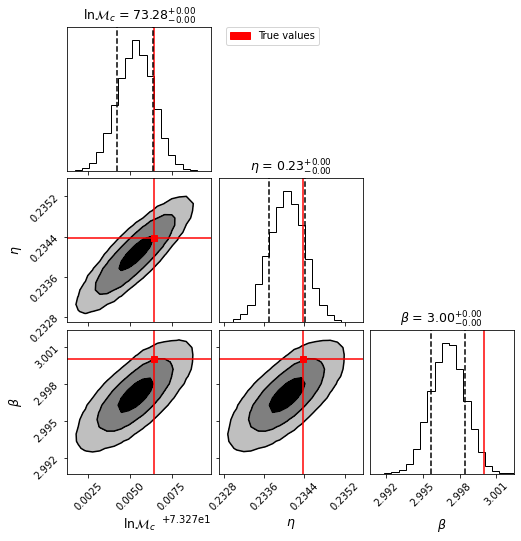

In [22]:
labels = [r'$\ln\mathcal{M}_c$', r'$\eta$', r'$\beta$']
truths=[logMchirp_true,eta_true,beta_true]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()

### Fisher matrix predictions

We calculate the waveform derivatives that will enter the Fisher matrix with the finite difference method, 

$$ \frac{\partial h_m(f;\Theta^i)}{\partial \Theta^i} \approx \frac{h_m(f;\Theta^i+ \delta\Theta^i)-h_m(f;\Theta^i -\delta\Theta^i)}{2 \delta\Theta^i} $$

where $\Theta=\{\log \mathcal{M}_c,\eta,\beta\}$

In [23]:
# Derivative wrt Mc.

lnMc_delta = 1e-4
pars_p = [pars[0] + lnMc_delta,pars[1],pars[2]]
pars_m = [pars[0] - lnMc_delta,pars[1],pars[2]]
d_dlnMc_ref = (htilde(freq,Deff_true,pars_p,tune)
           -htilde(freq,Deff_true,pars_m,tune))/(2*lnMc_delta)

# Derivative wrt eta.
eta_delta = 1e-6
pars_p = [pars[0],pars[1] + eta_delta,pars[2]]
pars_m = [pars[0],pars[1] - eta_delta,pars[2]]
d_deta_ref = (htilde(freq,Deff_true,pars_p,tune)
          -htilde(freq,Deff_true,pars_m,tune))/(2*eta_delta)

# Derivative wrt beta

beta_delta = 1e-6
pars_p = [pars[0],pars[1],pars[2]+ beta_delta]
pars_m = [pars[0],pars[1],pars[2]- beta_delta]
d_dbeta_ref = (htilde(freq,Deff_true,pars_p,tune)
           -htilde(freq,Deff_true,pars_m,tune))/(2*beta_delta)

Build up the Fisher matrix

In [24]:
Ntot = 1

diff_vec =[d_dlnMc_ref, d_deta_ref, d_dbeta_ref]

fish_mix = np.eye(3*Ntot)
for i in range(0,3*Ntot):
    for j in range(0,3*Ntot):
        fish_mix[i,j] = inner_prod(diff_vec[i],diff_vec[j],PSD,delta_f)

In [25]:
# Does the Fisher matrix approximate well (within a few digits) the MCMC widths? 
# If not, then there is a problem.

print('FM width predictions:',np.sqrt(np.diag(np.linalg.inv(fish_mix))))
print('MC width predictions:',  [np.round(np.sqrt(np.var(flat_samples[:,:,i])),17) 
                                 for i in range(0,3*Ntot)])

FM width predictions: [0.00105399 0.00034916 0.00139809]
MC width predictions: [0.00108603121636342, 0.00035971608762649, 0.00139957389728977]


Calculate biases from noise using

$$\Delta\Theta^i_{\text{noise}} =\Gamma^{ij}b_j$$

where the bias vector in this case where biases come from noise is

$$b_j = \left(\frac{\partial h}{\partial \Theta^j}\bigg|\, n_f + \Delta H_\text{conf}\right)$$

In [26]:
# Inverse of the full fisher matrix

print('condition number full FM: ',np.linalg.cond(fish_mix))
FM_inv = np.linalg.inv(fish_mix)

# bias vector 

noise = n_f + DeltaH

b = [inner_prod(i,noise,PSD,delta_f) for i in diff_vec]

# Inference biases

biases = np.matmul(FM_inv,b)

condition number full FM:  14884.872520719971


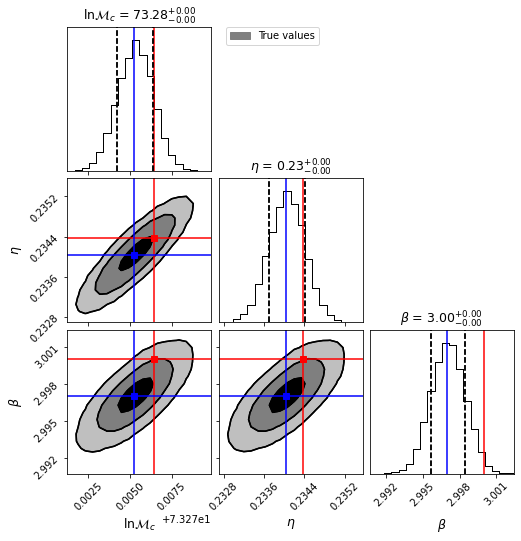

In [27]:
truths_bias =[logMchirp_true + biases[0], eta_true + biases[1 ], beta_true + biases[2]]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)
fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths_bias,
                    truth_color='blue', 
                    color='black',**CORNER_KWARGS, fig=fig)

red_patch = mpatches.Patch(color='gray', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
#plt.savefig('ouch.pdf')
plt.show()